# Final Classifier for Music

## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, confusion_matrix, make_scorer, classification_report
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

## Data Loading

In [3]:
def loadJSON(path):
    with open(path, 'r') as f:
        return json.load(f)
    
def loadPCA():
    X_train_pca = pd.read_csv(r'data/music_train_pca.csv')

    y_train_pca = np.array(X_train_pca.iloc[:, -1])
    non_music = X_train_pca[y_train_pca == 0]
    music = X_train_pca[y_train_pca == 1][:len(X_train_pca[y_train_pca == 0])]
    X_train_pca = music.append(non_music, ignore_index=True).sample(frac=1, random_state = 0)
    y_train_pca = np.array(X_train_pca.iloc[:, -1])
    X_train_pca = X_train_pca.iloc[:,:-1].values

    print("Loaded PCA training set")
    
    X_val_pca = pd.read_csv(r'data/music_validation_pca.csv').values
    y_val_pca = X_val_pca[:,-1]
    X_val_pca = X_val_pca[:,:-1]
    print("Loaded PCA validation set")
    
    scaler = StandardScaler()
    scaler.fit(X_train_pca)
    X_train_scaled = scaler.transform(X_train_pca)
    X_val_scaled = scaler.transform(X_val_pca)
    
    return (X_train_scaled, y_train_pca, X_val_scaled, y_val_pca)

train_data_path = r'data/music_train_set.csv'
val_data_path = r'data/music_validation_set.csv'
feature_path = r'data/indixes_music.csv'
print("Start Program")
dataset_train = pd.read_csv(train_data_path)
print("Loaded training set")
dataset_val = pd.read_csv(val_data_path)
print("Loaded validation set")
features = pd.read_csv(feature_path)
print("Loaded features")

dataset_train = dataset_train.sample(frac=1, random_state = 0)

y_train = np.array(dataset_train.iloc[:, -1])

#Undersampling
non_music = dataset_train[y_train == 0]
music = dataset_train[y_train == 1][:len(dataset_train[y_train == 0])]
dataset_train = music.append(non_music, ignore_index=True).sample(frac=1, random_state = 0)
y_train = np.array(dataset_train.iloc[:, -1])
y_val = np.array(dataset_val.iloc[:, -1])
print("Split data")

X_train_pca, y_train_pca, X_val_pca, y_val_pca = loadPCA()

Start Program
Loaded training set
Loaded validation set
Loaded features
Split data
Loaded PCA training set
Loaded PCA validation set


In [4]:
def profit_score(y_true, y_pred, **kwargs):
    rewardDict = dict()
    #(True Value, Predicted Value)
    rewardDict[(0,0)] = 0
    rewardDict[(0,1)] = -3
    rewardDict[(1,0)] = 0
    rewardDict[(1,1)] = 1
    
    reward = 0
    if len(y_true) != len(y_pred):
        print("Arrays are of two different lengths!!!")
        return -1000000
    for index in range(len(y_true)):
        reward += rewardDict[(y_true[index],y_pred[index])]
    return reward

def plotROC(solution, prediction, classifierName):
    lw = 2
    fpr, tpr, _ = roc_curve(solution, prediction)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {}'.format(classifierName))
    plt.legend()
    plt.show()
    
def getClassifiers():
    logistic_regression = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                             intercept_scaling=1, max_iter=100, multi_class='warn',
                                             penalty='l2', random_state=None, solver='liblinear',
                                             tol=0.0001, verbose=0, warm_start=False)
    random_forest = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                                           max_depth=1000, max_features='auto', max_leaf_nodes=None,
                                           min_impurity_decrease=0.0, min_impurity_split=None,
                                           min_samples_leaf=2, min_samples_split=6,
                                           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                                           oob_score=False, random_state=0, verbose=0, warm_start=False)
    nn = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
                       beta_2=0.999, early_stopping=False, epsilon=1e-08,
                       hidden_layer_sizes=100, learning_rate='constant',
                       learning_rate_init=0.001, momentum=0.9,
                       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
                       random_state=0, shuffle=True, solver='adam', tol=0.0001,
                       validation_fraction=0.1, verbose=False, warm_start=False)
    voting = VotingClassifier(estimators=[('lr', logistic_regression), ('rf', random_forest), ('nn', nn)], voting="soft")
    return [(logistic_regression,"logistic_regression"), (random_forest,"random_forest"), (nn,"Neural Network"), (voting, "ensemble")]
    
def parameterGridSearch():
    parameter_space = {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'activation': ['tanh', 'relu', 'logistic'],
        'solver': ['sgd', 'adam', 'lbfgs'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive']}

    classifier = MLPClassifier(max_iter=50)
    name = "Neural Network"

    clf = GridSearchCV(classifier, parameter_space, n_jobs=-1, cv=3, scoring=make_scorer(profit_score), iid = False)
    clf.fit(X_train, y_train)

    # Best paramete set
    print('Best parameters found:\n', clf.best_params_)

    # All results
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    y_true, y_pred = y_val , clf.predict(X_val)

    print('Results on the test set:')
    print(classification_report(y_true, y_pred))

## Post processing

In [5]:
def post_processing(y):
    return filtering(majority_vote(y))

def majority_vote(y, window = 100):
    """
    Slides a window over the input and puts the label to a majority vote
    """
    y_new = []
    maxR = len(y)
    for i in range(maxR):
        l = i - window
        if l < 0:
            l = 0
        r = i + window
        if r > maxR - 1:
            r = maxR - 1
        y_new.append(np.bincount(y[l:r]).argmax())
    return y_new

def filtering(y, threshold = 450):
    """
    Filters out segments of music that are shorter than 1.5 minutes 
    Every Frame is 200ms * 5 * 60 * 1.5 = 450
    """
    y_string = str1 = ''.join(str(e) for e in y)
    y_new = np.zeros(len(y))
    musicIndexStart = 0
    musicIndexStop = 0
    while musicIndexStart != -1 and musicIndexStop != -1:
        if musicIndexStop - musicIndexStart > threshold:
            y_new[musicIndexStart:musicIndexStop] = np.ones(musicIndexStop - musicIndexStart)
        musicIndexStart = y_string.find("1",musicIndexStop)
        musicIndexStop = y_string.find("0",musicIndexStart)
    return y_new

## Train Logistic Regression

Max possible Profit of the validation set: 31589
|Training on RF
logistic_regression
|-Confusion Matrix: [0.35477799 0.0506503  0.06487982 0.52969188]
|-Accuracy: 88.45%
|-Profit: 20069 / 63.53%
L==============================


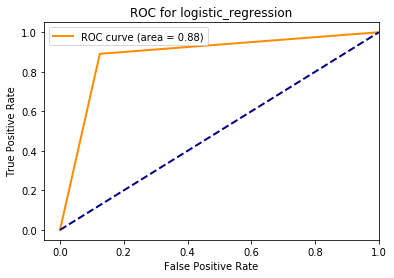

random_forest
|-Confusion Matrix: [0.33219146 0.07323684 0.05974138 0.53483032]
|-Accuracy: 86.7%
|-Profit: 16742 / 53.0%
L==============================


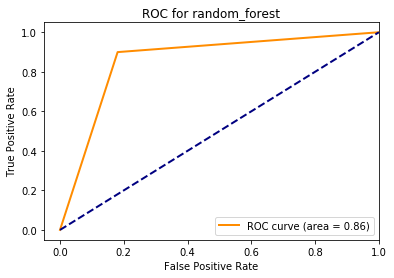

Neural Network
|-Confusion Matrix: [0.31958064 0.08584765 0.04722468 0.54734702]
|-Accuracy: 86.69%
|-Profit: 15397 / 48.74%
L==============================


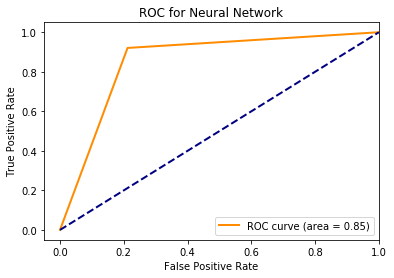

ensemble
|-Confusion Matrix: [0.33172091 0.07370739 0.04906925 0.54550246]
|-Accuracy: 87.72%
|-Profit: 17234 / 54.56%
L==============================


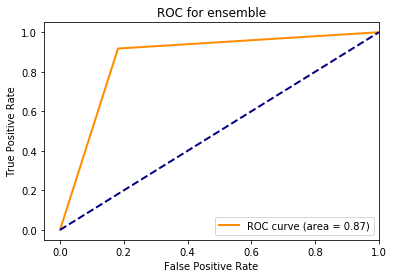

|Training on SVM
logistic_regression
|-Confusion Matrix: [0.35690489 0.04852341 0.06405165 0.53052005]
|-Accuracy: 88.74%
|-Profit: 20452 / 64.74%
L==============================


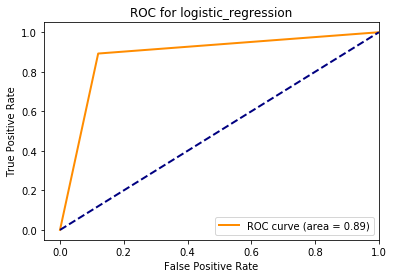

random_forest
|-Confusion Matrix: [0.31777372 0.08765458 0.05962845 0.53494325]
|-Accuracy: 85.27%
|-Profit: 14450 / 45.74%
L==============================


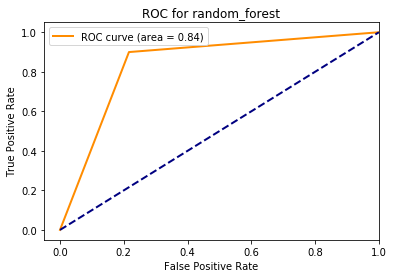

Neural Network
|-Confusion Matrix: [0.31890305 0.08652525 0.04882456 0.54574714]
|-Accuracy: 86.47%
|-Profit: 15204 / 48.13%
L==============================


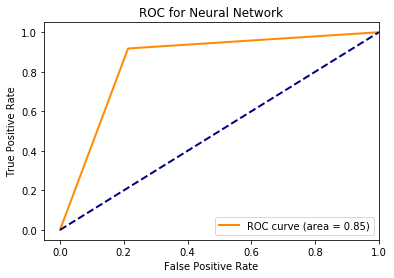

ensemble
|-Confusion Matrix: [0.33396074 0.07146756 0.04935158 0.54522012]
|-Accuracy: 87.92%
|-Profit: 17576 / 55.64%
L==============================


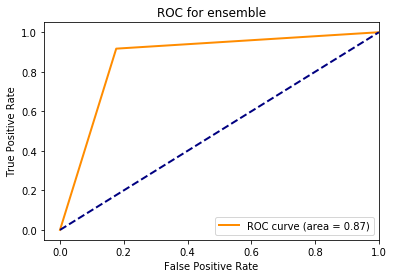

|Training on RForSVM
logistic_regression
|-Confusion Matrix: [0.35686725 0.04856105 0.06399518 0.53057652]
|-Accuracy: 88.74%
|-Profit: 20449 / 64.73%
L==============================


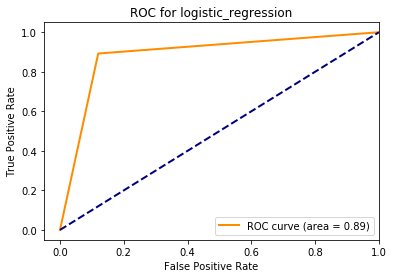

random_forest
|-Confusion Matrix: [0.33143857 0.07398972 0.05974138 0.53483032]
|-Accuracy: 86.63%
|-Profit: 16622 / 52.62%
L==============================


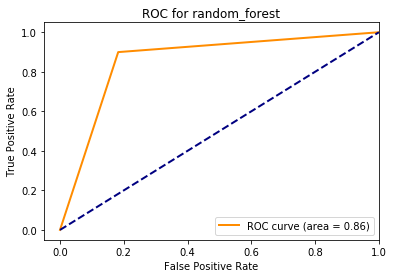

Neural Network
|-Confusion Matrix: [0.31519509 0.09023321 0.04769523 0.54687647]
|-Accuracy: 86.21%
|-Profit: 14673 / 46.45%
L==============================


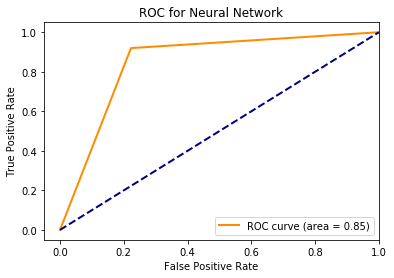

ensemble
|-Confusion Matrix: [0.33036571 0.07506258 0.04857987 0.54599183]
|-Accuracy: 87.64%
|-Profit: 17044 / 53.96%
L==============================


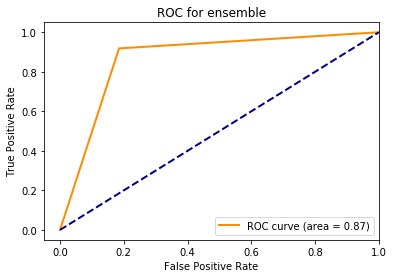

|Training on RFandSVM
logistic_regression
|-Confusion Matrix: [0.35483446 0.05059384 0.0675902  0.5269815 ]
|-Accuracy: 88.18%
|-Profit: 19934 / 63.1%
L==============================


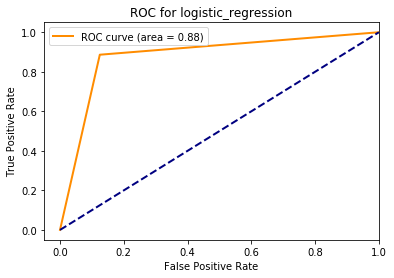

random_forest
|-Confusion Matrix: [0.34052965 0.06489864 0.04991624 0.54465546]
|-Accuracy: 88.52%
|-Profit: 18593 / 58.86%
L==============================


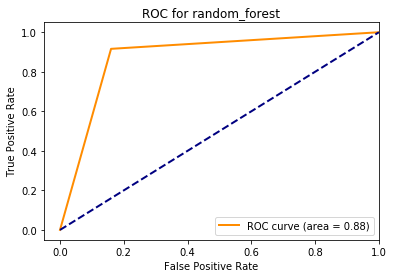

Neural Network
|-Confusion Matrix: [0.32599898 0.07942931 0.04876809 0.54580361]
|-Accuracy: 87.18%
|-Profit: 16338 / 51.72%
L==============================


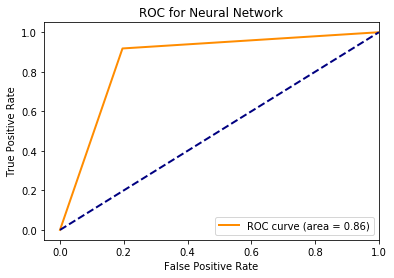

ensemble
|-Confusion Matrix: [0.3438047  0.0616236  0.04995389 0.54461782]
|-Accuracy: 88.84%
|-Profit: 19113 / 60.51%
L==============================


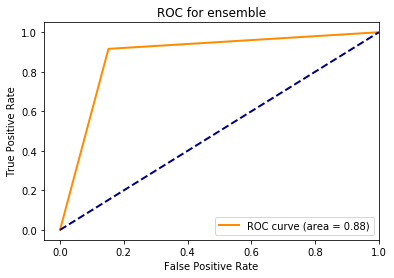

88.84
20452
|Training on PCA
logistic_regression
|-Confusion Matrix: [0.38327467 0.02215363 0.05834855 0.53622315]
|-Accuracy: 91.95
|-Profit: 24958 / 79.01%
L==============================


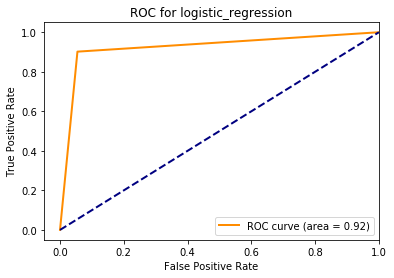

random_forest
|-Confusion Matrix: [0.40030868 0.00511961 0.11901222 0.47555949]
|-Accuracy: 87.59
|-Profit: 24450 / 77.4%
L==============================


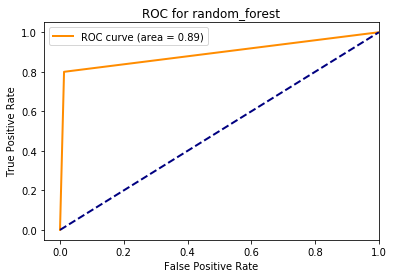

Neural Network
|-Confusion Matrix: [0.40219089 0.0032374  0.27508517 0.31948653]
|-Accuracy: 72.17
|-Profit: 16458 / 52.1%
L==============================


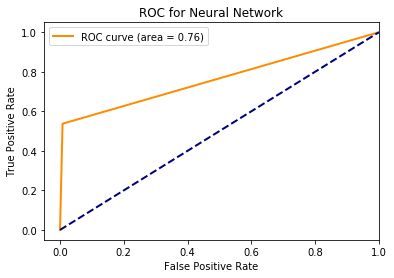

ensemble
|-Confusion Matrix: [0.39910407 0.00632423 0.09034614 0.50422556]
|-Accuracy: 90.33
|-Profit: 25781 / 81.61%
L==============================


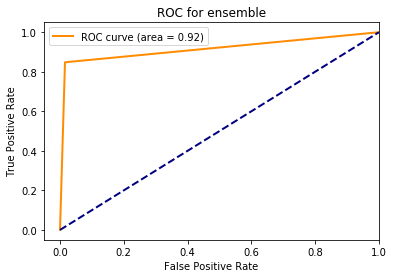

In [6]:
def analyzePCA():
    max_val_score = np.sum(y_val_pca == 1)
    print("===============================")
    print("|Training on PCA")
    print("===============================")

    for classifier, name in getClassifiers():
        print(name)
        classifier.fit(X_train_pca, y_train_pca)
        y_pred = post_processing(classifier.predict(X_val_pca))
        accuracy = np.around(accuracy_score(y_val_pca, y_pred) * 100, decimals = 2)
        val_profit = profit_score(y_val_pca, y_pred)
        print("|-Confusion Matrix: {}".format(confusion_matrix(y_val_pca, y_pred).ravel()/len(y_pred)))
        print("|-Accuracy: {}".format(accuracy))
        print("|-Profit: {} / {}%".format(val_profit, np.around(val_profit* 100/max_val_score,decimals = 2)))
        print("L==============================")
        plotROC(y_val_pca, y_pred, name)

def findBestClassifier():
    max_val_score = np.sum(y_val == 1)
    accuracies = []
    profits = []
    print("Max possible Profit of the validation set: {}".format(max_val_score))

    for column in features:
        f = features[column].dropna().tolist()
        print("===============================")
        print("|Training on {}".format(column))
        print("===============================")
        X_train = dataset_train[f].values
        X_val = dataset_val[f].values
            #Scaling all features to mean 0 variance 1
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_val = scaler.transform(X_val)

        for classifier, name in getClassifiers():
            print(name)
            classifier.fit(X_train, y_train)
            y_pred = post_processing(classifier.predict(X_val))
            accuracy = np.around(accuracy_score(y_val, y_pred) * 100, decimals = 2)
            val_profit = profit_score(y_val, y_pred)
            accuracies.append(accuracy)
            profits.append(val_profit)
            print("|-Confusion Matrix: {}".format(confusion_matrix(y_val, y_pred).ravel()/len(y_pred)))
            print("|-Accuracy: {}%".format(accuracy))
            print("|-Profit: {} / {}%".format(val_profit, np.around(val_profit* 100/max_val_score,decimals = 2)))
            print("L==============================")
            plotROC(y_val, y_pred, name)
    print(max(accuracies))
    print(max(profits))
    
def trainBestClassifier():
    f = features.SVM.dropna().tolist()
    X_train = dataset_train[f].values
    X_val = dataset_val[f].values

    #Scaling all features to mean 0 variance 1
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    for classifier, name in getClassifiers():    
        classifier.fit(X_train_scaled, y_train)

        y_pred = post_processing(classifier.predict(X_val_scaled))
        accuracy = np.around(accuracy_score(y_val, y_pred) * 100, decimals=2)
        val_profit = profit_score(y_val, y_pred)
        print("Confusion Matrix: {}".format(confusion_matrix(y_val, y_pred).ravel()/len(y_pred)))
        print("Accuracy: {}%".format(accuracy))
        print("Profit: {} / {}%".format(val_profit, np.around(val_profit* 100/max_val_score, decimals=2)))
        plotROC(y_val, y_pred, name)
        
findBestClassifier()
analyzePCA()